# **Solid waste detection with CNN**
* Business Problem
* Data Understanding
* Data Preparation
* Modeling
* Evaluation




In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install tensorflow

In [17]:
# reading and processing data
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

# closing warning
import warnings
warnings.filterwarnings("ignore")

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [18]:
dir_path = "/content/gdrive/MyDrive/trashnet"

In [19]:
# target size and labels encoding

target_size = (224,224)

waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}


In [20]:
def load_datasets(dir_path):
    x = []  # matris of images
    labels = []  # labels

    image_paths = sorted(list(paths.list_images(dir_path)))

    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)

        x.append(img)

        label = image_path.split(os.path.sep)[-2]  # path'de sondan ikinci öge class ismi yani label
        labels.append(waste_labels[label])

    x, labels = shuffle(x, labels, random_state=42)  # Dataset karıştırılıyor

    # shape ve class bilgilerini yazdırma
    print(f"x shape: {np.array(x).shape}")
    print(f"Number of label class: {len(np.unique(labels))}, Number of observations: {len(labels)}")

    return x, labels


In [21]:
x, labels = load_datasets(dir_path)

x shape: (2547, 224, 224, 3)
Number of label class: 6, Number of observations: 2547


In [22]:
input_shape = (x[0].shape[0], x[0].shape[1], x[0].shape[2])  # (height, width, channels)
print(input_shape)

(224, 224, 3)


**Visualize of images**

In [23]:
def visualize_img(image_batch, label_batch):
    num_images = min(len(image_batch), 10)  # Maksimum 10 görsel göster
    plt.figure(figsize=(10, 10))

    for n in range(num_images):
        ax = plt.subplot(2, 5, n + 1)  # 2 satır, 5 sütun
        plt.imshow(image_batch[n])
        label_name = list(waste_labels.keys())[list(waste_labels.values()).index(label_batch[n])]
        plt.title(label_name.title())
        plt.axis("off")
    plt.show()


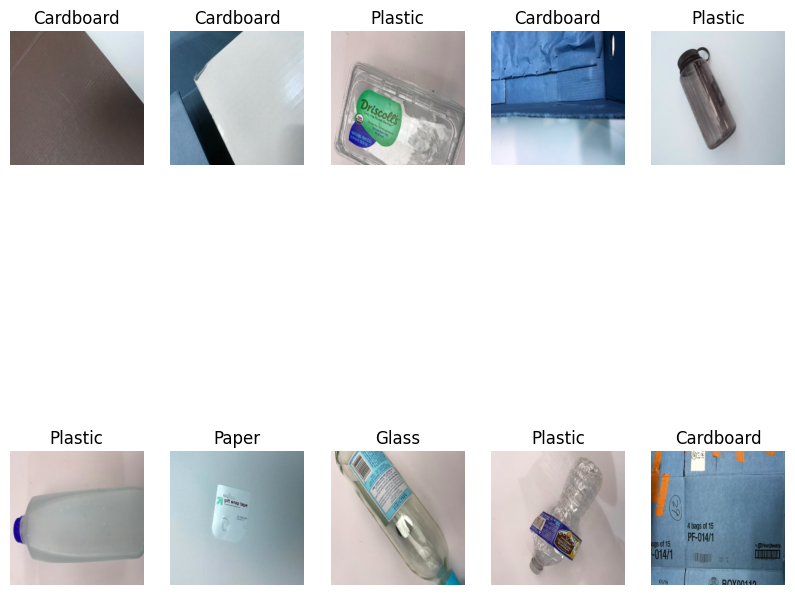

In [24]:
visualize_img(x, labels)

# **Data Preparation & augmentation**
* **ImageDataGenerator** sınıfı, veriyi artırma ve normalleştirme işlemleri yaparak modelin daha sağlam bir şekilde öğrenmesini sağlar.
* **flow_from_directory** fonksiyonu, belirtilen dizinden resimleri okur, etiketlerini belirler ve model için uygun hale getirir.
* train veri kümesinde artırmalar yapılırken (flip, zoom, kaydırma vb.), test veri kümesinde sadece resimlerin ölçeklendirilmesi yeterlidir.


In [25]:
# a generator for train dataset
train = ImageDataGenerator(
    horizontal_flip= True,               # Resimleri yatay çevirme
    vertical_flip = True,                 # Resimleri dikey çevirme
    validation_split = 0.1,               # Verilerin %10'unu doğrulama seti olarak ayırma
    rescale = 1./255,                     # Resimleri 0-1 aralığına ölçekleme (piksel değerlerini 0 ile 1 arasında normalize eder)
    shear_range = 0.1,                    # Resimleri yatay olarak çekme (deforme etme)
    zoom_range = 0.1,                     # Resimleri rastgele yakınlaştırma
    width_shift_range = 0.1,              # Resimleri yatayda rastgele kaydırma
    height_shift_range = 0.1              # Resimleri dikeyde rastgele kaydırma
)

# a generator for test dataset
test = ImageDataGenerator(
    rescale = 1/255,                    # Test resimlerini de 0-1 aralığına ölçekleme
    validation_split = 0.1              # Test verisinin %10'unu doğrulama seti olarak ayırma
)

In [26]:
train_generator = train.flow_from_directory(directory = dir_path,
                                            target_size = (target_size),
                                            class_mode = "categorical",
                                            subset = "training")

test_genarotor = test.flow_from_directory(directory = dir_path,
                                            target_size = (target_size),
                                            batch_size = 251,  #  # Batch boyutu (aynı anda kaç resim işleneceği)
                                            class_mode = "categorical",
                                            subset = "validation")

Found 2294 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


# **Modeling**

*   Sequential
*   Convolution Layer, Conv2D
*   Pooling Layer
*   Activation Layer
*   Flattening Layer
*   Dense Layer
*   Dropout Layer



In [27]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = "same", input_shape=(input_shape), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = "same", input_shape=(input_shape), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = "same", input_shape=(input_shape), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation="relu")) # bir katmanın çıkışını diğerinin girişine bağlar
model.add(Dropout(rate=0.2)) # her katmanda %20 oranında nöronlar söndürülecek,overfitting engellenecek

model.add(Dense(units=32, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation="softmax")) # output layer

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,627,366 (6.21 MB)

 Trainable params: 1,627,366 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
None", batch size’ı temsil eder ve model tanımlanırken genellikle belirtilmez.
Batch size, modelin aynı anda kaç örnek üzerinde işlem yapacağını belirtir.
Eğitim sırasında fit metodu çağrıldığında batch size belirtilir.
Bu nedenle, model özeti girişteki örnek sayısını bilmediği için "None" gösterir.

Conv2D (Convolution Layer): Giriş verilerinde (ör. resimler) belirli özellikleri (ör. kenarlar, dokular) yakalar.
Bu katman, filtreler (weights) kullanır.Amaç: Görüntüdeki çıkarılmış özellikler ile ilişkileri öğrenmek

MaxPooling2D: feature map boyutunu azaltır (ör. 224x224 → 112x112).
Bu, daha az hesaplama ve overfitting'i engellemek için kullanılır.

Flatten: 2D veri yapısını (ör. 28x28x32) 1D vektöre dönüştürür. Bu, Fully Connected katmanlara giriş sağlar.

Dense (Tam Bağlantılı Katman): Giriş vektörünü öğrenir ve sınıflandırma yapar.

Dropout: Overfitting’i azaltmak için bazı nöronları rastgele devre dışı bırakır.

Model:
3 adet Conv2D ve MaxPooling2D katmanları ile özellikler çıkarır ve boyutları küçültür.
Flatten katmanı ile 1D vektöre çevirir.
Dense katmanları ile bu özellikleri kullanarak sınıflandırma yapar.
Dropout ile aşırı öğrenmeyi önler.
Son katman, softmax aktivasyon fonksiyonu ile tahmin edilen sınıfları verir.

'''

# **Optimization**

In [30]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
              # başarı değerlendirme metrikleri

# binary_crossentropy -> for two class

In [40]:
# Define the EarlyStopping callback
early_stopping = [EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose = 1,
                               mode = "min",
                               restore_best_weights=True),

                               ModelCheckpoint(filepath= "mymodel.keras",
                                               monitor="val_loss",
                                               mode = "min",
                                               save_best_only = True,
                                               save_weights_only = False,
                                               verbose = 1)]

**train loss değeri test loss değerinden daha yüksek çıkması beklenir**

In [41]:
# Train the model with the EarlyStopping callback
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_genarotor,
    callbacks=[early_stopping],
    steps_per_epoch = 2276//32,
    validation_steps = 251//32
)

Epoch 1/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5107 - loss: 1.1926 - precision: 0.7413 - recall: 0.3133
Epoch 1: val_loss improved from inf to 1.19458, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.5109 - loss: 1.1925 - precision: 0.7412 - recall: 0.3134 - val_accuracy: 0.5257 - val_loss: 1.1946 - val_precision: 0.7547 - val_recall: 0.3162
Epoch 2/15
 1/71 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.5938 - loss: 1.3155 - precision: 0.7143 - recall: 0.3125
Epoch 2: val_loss improved from 1.19458 to 1.15741, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.5938 - loss: 1.3155 - precision: 0.7143 - recall: 0.3125 - val_accuracy: 0.5217 - val_loss: 1.1574 - val_precision: 0.8081 - val_recall: 0.3162
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5144 - loss: 1.1913 - precision: 0.7542 - recall: 0.3417
Epoch 3: val_loss did not improve from 1.15741
71/71 ━━━━━━━━━━━━━━━━━━━━ 187s 3

# **Accuracy and Loss Graphs**

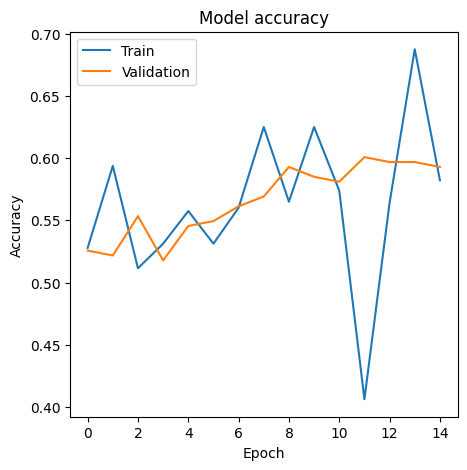

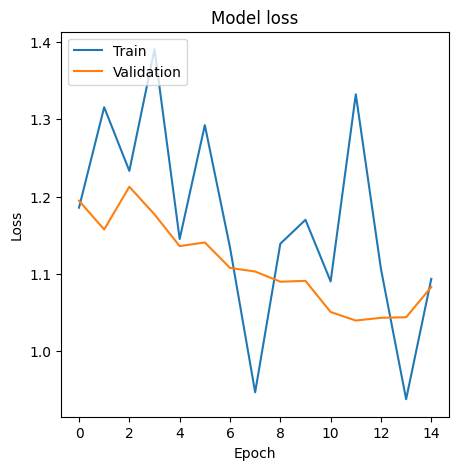

In [43]:
# Plot training & validation accuracy values
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Evaluation - Confusion Matrix**

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5997 - loss: 1.0403 - precision: 0.7869 - recall: 0.3805
Loss: 1.0396374464035034
Precision: 0.7868852615356445
Recall: 0.3794466257095337
Accuracy: 0.6007905006408691
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step
              precision    recall  f1-score   support

   cardboard       0.25      0.17      0.21        40
       glass       0.21      0.33      0.26        51
       metal       0.22      0.17      0.19        41
       paper       0.28      0.37      0.32        59
     plastic       0.19      0.10      0.13        49
       trash       0.00      0.00      0.00        13

    accuracy                           0.23       253
   macro avg       0.19      0.19      0.18       253
weighted avg       0.22      0.23      0.22       253



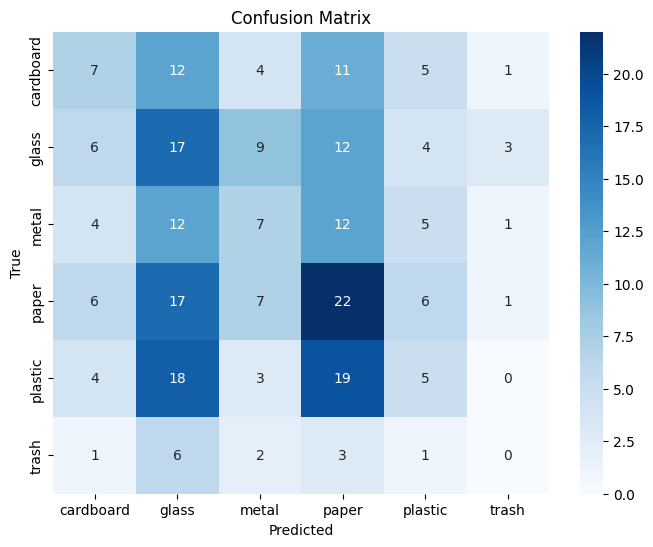

In [44]:
# Evaluate the model
loss, precision, recall, accuracy = model.evaluate(test_genarotor)

print(f"Loss: {loss}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

# Get predictions
predictions = model.predict(test_genarotor)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Get true labels
y_true = test_genarotor.classes

# Generate and print the classification report
print(classification_report(y_true, y_pred, target_names=list(waste_labels.keys())))

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(waste_labels.keys()),
            yticklabels=list(waste_labels.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


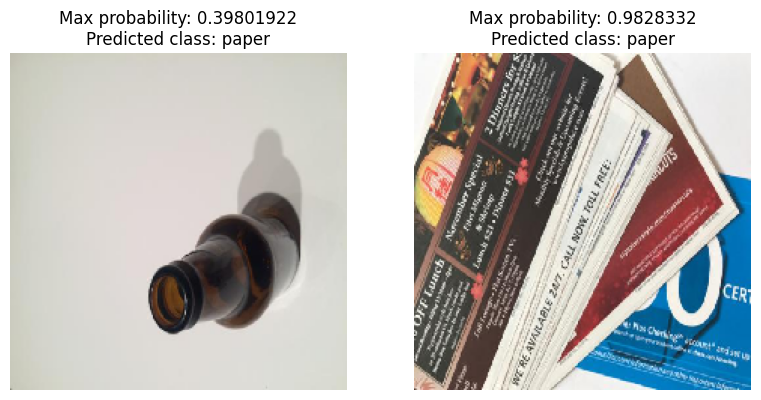

In [47]:
waste_labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

def model_testing(path):
    img = image.load_img(path, target_size=(224, 224))  # Hedef boyutu belirtin
    img_array = image.img_to_array(img)  # img_to_array metodunu doğru şekilde çağırın
    img_array = img_array / 255.0  # Normalizasyon
    p = model.predict(img_array.reshape(1, 224, 224, 3))  # Model tahmini
    predicted_class = np.argmax(p[0])  # En yüksek olasılık sınıfı

    return img, p, predicted_class

# Model testi için iki resim
img1, p1, predicted_class1 = model_testing("/content/gdrive/MyDrive/trashnet/glass/glass1.jpg")
img2, p2, predicted_class2 = model_testing("/content/gdrive/MyDrive/trashnet/paper/paper100.jpg")

# Grafik çizimi
plt.figure(figsize=(20, 60))

plt.subplot(141)
plt.axis("off")
plt.imshow(img1)  # Resmi çiz
plt.title("Max probability: " + str(np.max(p1[0], axis=-1)) + "\nPredicted class: " +
          str(list(waste_labels.keys())[predicted_class1]))  # Tahmin ve sınıf etiketi

plt.subplot(142)
plt.axis("off")
plt.imshow(img2)
plt.title("Max probability: " + str(np.max(p2[0], axis=-1)) + "\nPredicted class: " +
          str(list(waste_labels.keys())[predicted_class2]))

plt.show()